In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2)

class Comparison:
    def __init__(self, bodies = 100, time_steps = [100, 1000, 10000], thread_nums = [1, 2, 4, 8, 10, 12, 16, 32]):
        self.bodies = bodies
        self.time_steps = time_steps
        self.thread_nums = thread_nums

        self.values_iter = []
        self.values_paral = []

        self.readFromFilesIterative()
        self.readFromFilesParallel()

    def readFromFilesIterative(self, **kwargs):
        bodies = self.bodies
        time_steps = self.time_steps

        if 'bodies' in kwargs:
            bodies = kwargs['bodies']

        if 'time_steps' in kwargs:
            time_steps = kwargs['time_steps']

        for i in time_steps:
            f = open('Iterative Ver/results_' + str(bodies) + '/' + str(i) + '_Timesteps', 'r')
            self.values_iter.append(float(f.read()))
            f.close()
    
    def readFromFilesParallel(self, **kwargs):
        bodies = self.bodies
        time_steps = self.time_steps
        thread_nums = self.thread_nums

        if 'bodies' in kwargs:
            bodies = kwargs['bodies']

        if 'time_steps' in kwargs:
            time_steps = kwargs['time_steps']

        if 'thread_nums' in kwargs:
            thread_nums = kwargs['thread_nums']

        for i in time_steps:
            for j in thread_nums:
                f = open('Parallel Ver/results_' + str(bodies) + '/timeSteps_' + str(i) + '/' + str(j) + '_Threads', 'r')
                self.values_paral.append(float(f.read()))
                f.close()

    def printComparison(self):
        subplot_num = len(self.time_steps)
        threads_num = len(self.thread_nums)

        fig, axs = plt.subplots(subplot_num, sharex=True)

        fig.set_figheight(10)
        fig.set_figwidth(20)

        plt.xlabel("The Number Of Threads Used")

        fig.text(0.08, 0.5, "Time In Processor Clocks", ha='center', va='center', rotation='vertical')

        if subplot_num != 1:
            for i in range(subplot_num):
                axs[i].plot([self.values_iter[i]] * threads_num)
                axs[i].plot(self.values_paral[i * threads_num : i * threads_num + threads_num])
                axs[i].set_title("Time required for " + str(self.bodies) + " points travelling for " + str(self.time_steps[i]) + " timesteps")
                axs[i].set_xticklabels(['']+self.thread_nums)
        else:
            axs.plot([self.values_iter[0]] * threads_num)
            axs.plot(self.values_paral)
            axs.set_title("Time required for " + str(self.bodies) + " points travelling for " + str(self.time_steps[0]) + " timesteps")
            axs.set_xticklabels(['']+self.thread_nums)

        

In [23]:
Points100 = Comparison()

C:\Users\Razmik\AppData\Local\Temp\ipykernel_8544\2680532350.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['']+self.thread_nums)


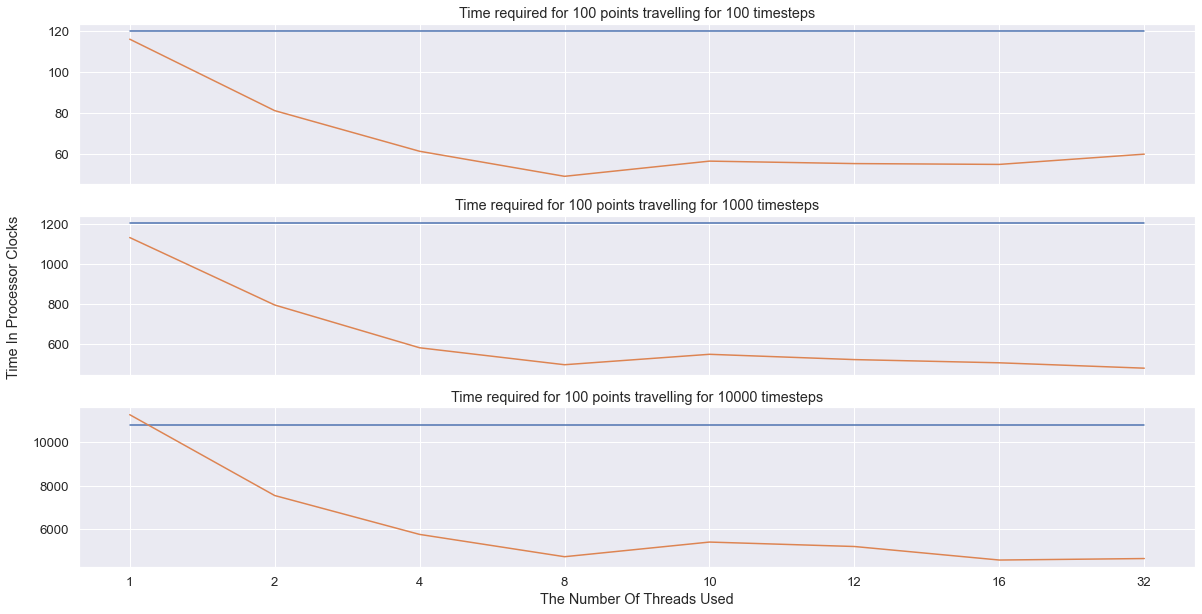

In [24]:
Points100.printComparison()

C:\Users\Razmik\AppData\Local\Temp\ipykernel_8544\2680532350.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['']+self.thread_nums)


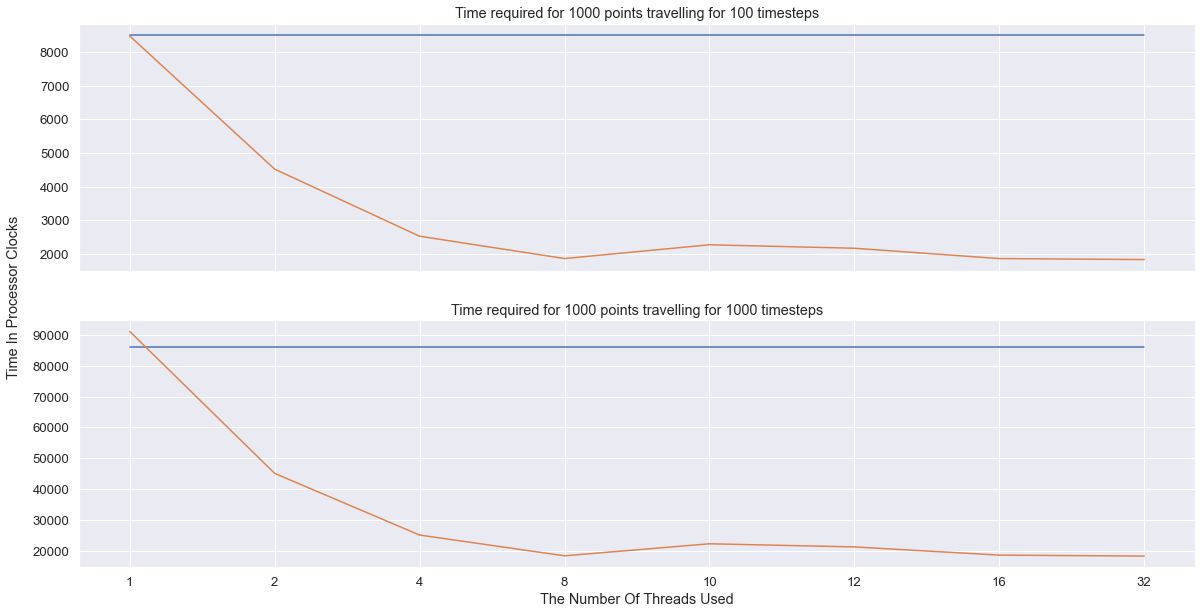

In [25]:
Points1000 = Comparison(bodies=1000, time_steps=[100, 1000])
Points1000.printComparison()

C:\Users\Razmik\AppData\Local\Temp\ipykernel_8544\2680532350.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(['']+self.thread_nums)


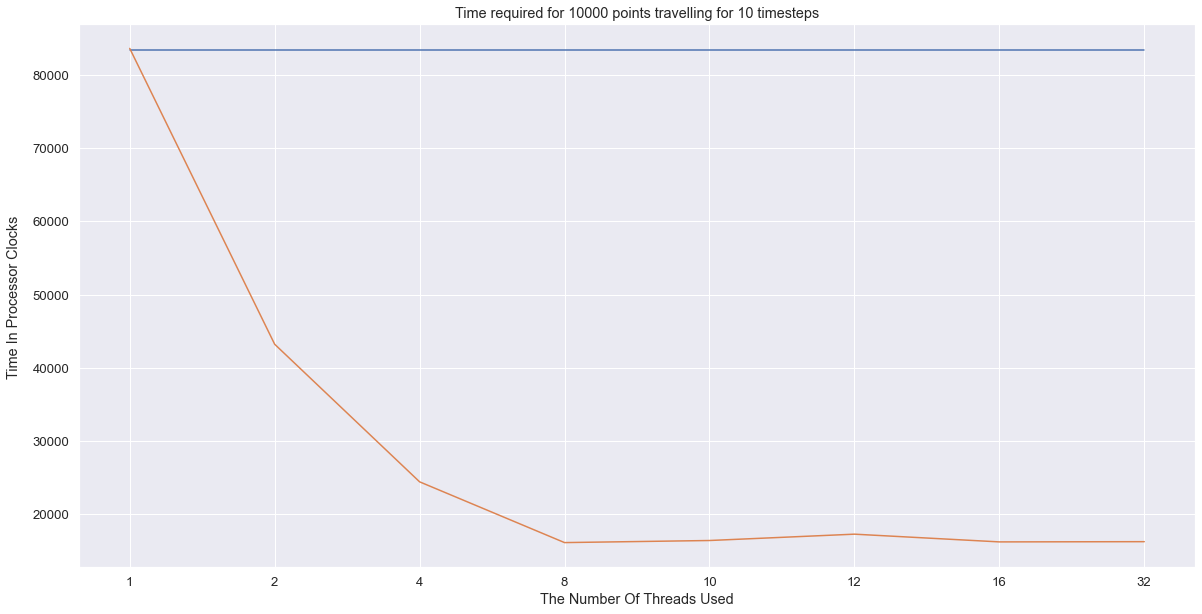

In [26]:
Points10000 = Comparison(bodies=10000, time_steps=[10])
Points10000.printComparison()